
# Fairness & Repair Exploratory Analysis
### Kushagra Ghosh

In data cleaning, the objective is to ensure that data can adhere to the right quality and integrity constraints. Our data has constraints (functional dependencies or FDs) that we want the database to satisfy (such as Zip Code -> City, State). There are countless algorithms for data repair that take in data and delete tuples, change values, or add different tuples to satisfy FDs using ML and statistics about the data. However, by changing the data, these repair algorithms may hurt one population. For example, by deleting a higher proportion of female tuples, there may be a lower percentage of females in the final data, swaying our statistics and create bias. We would like to verify our assumption that data repair algorithms can introduce bias. 

The idea of this exploration exercise is to see how query answers differ after specific data transformations. Specifically, does the data become distorted due to these transformations and then may lead the analyst to the wrong conclusion due to bias? 

### Original Census ACS PUMS Data

My first step was to retrive the dataset I am working with. Folktale is a package with various datasets, each with different tables and tasks to be predicted. I read the instructions and installed the package to work with the population dataset from here: https://github.com/zykls/folktables. This population dataset is from the American Community Survey Public Use Microdata Sample from https://www.census.gov/programs-surveys/acs/microdata/documentation.html.

In [1]:
%%capture
pip install folktables

In [2]:
from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


I generated a uniform random sample from each state with approximately 50% or 40% percentage for sex, and representation for different protected subpopulations (such as different races).

In [3]:
%%capture
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
original = data_source.get_data(density=0.01,download=True)

I also varied the density and random seed of my sampling from the US population dataset to see if I would also get a consistent distribution. From here on, I will be using the Sample 1 (original) since I do get a consistent distribution.

In [4]:
#Varying the density and the random seed
us_data2 = data_source.get_data(density=0.002,random_seed=12,download=True)

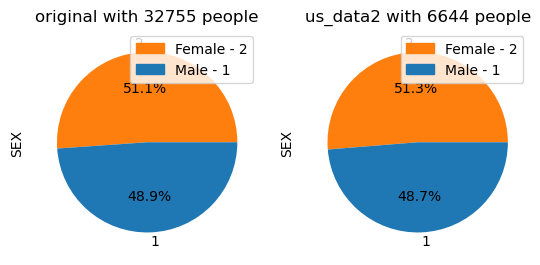

In [5]:
colors_mapping={1:'#1f77b4', 2:'#ff7f0e', 3:'#2ca02c', 4:'#d62728', 5:'#9467bd', 6:'#8c564b', 7:'#e377c2', 8:'#7f7f7f', 9:'#bcbd22', 10:'#17becf'}
legendOn = True
def piechart(title, df, ax, column, label_mapping, legendOn=False):
    labels = df[column].value_counts().keys()
    colors = [colors_mapping[l] for l in labels]
    df[column].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax, colors = colors)
    ax.set_title(title)
    if legendOn:
        handles = [plt.Rectangle((0,0),1,1, color=colors_mapping[label]) for label in labels]
        ax.legend(handles, [f"{label_mapping[l]} - {l}" for l in labels])
    
fig, axs = plt.subplots(1, 2)
sex_label_mapping = {1: 'Male', 2: 'Female'}
piechart(f"original with {original.shape[0]} people", original, axs[0], 'SEX', sex_label_mapping, legendOn)
piechart(f"us_data2 with {us_data2.shape[0]} people", us_data2, axs[1], 'SEX', sex_label_mapping, legendOn)
plt.show()

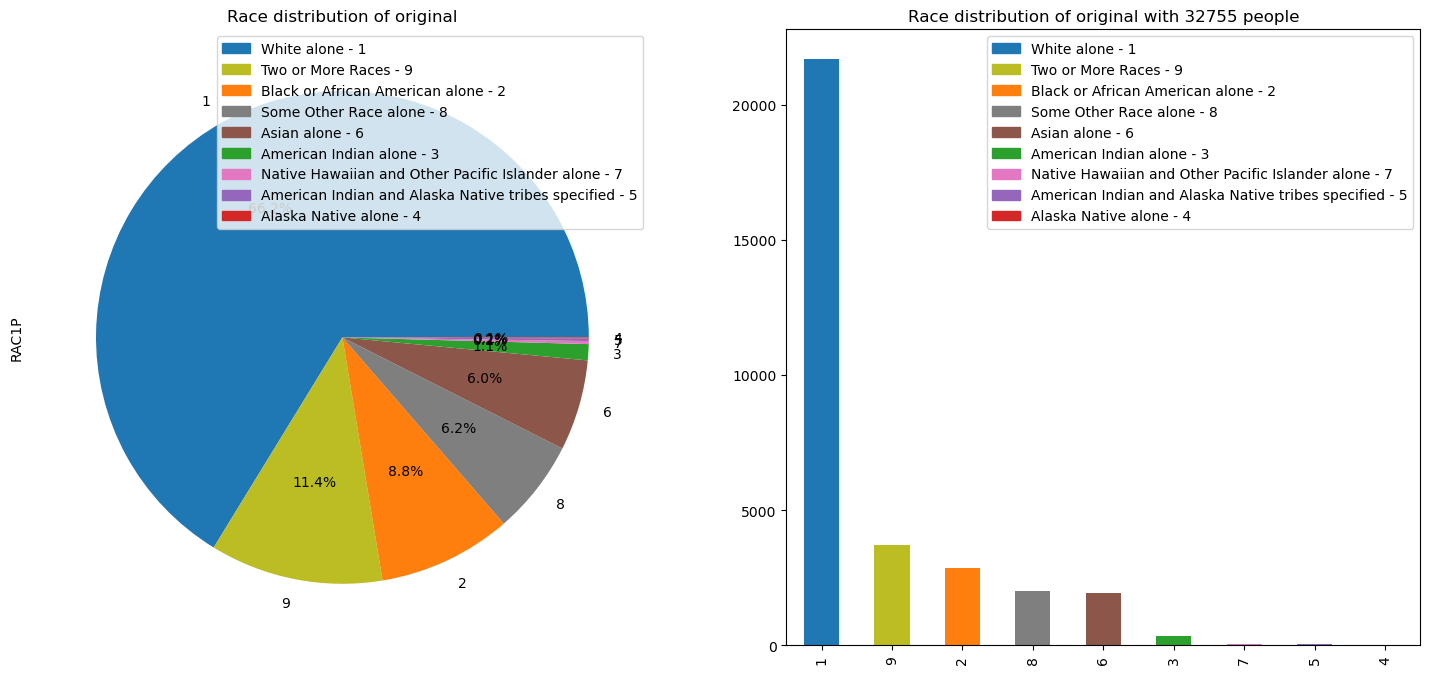

In [6]:
def barplotForCounts(title, df, ax, column, label_mapping, legendOn=False):
    labels = list(df[column].value_counts().keys())
    colors = [colors_mapping[l] for l in labels]
    df[column].value_counts().plot(kind="bar", ax=ax, color=colors)
    #ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #display(df[column].value_counts())
    if legendOn:
        handles = [plt.Rectangle((0,0),1,1, color=colors_mapping[label]) for label in labels]
        plt.legend(handles, [f"{label_mapping[l]} - {l}" for l in labels])
    ax.set_title(title)

fig, axs = plt.subplots(1,2, figsize=(18,8))
race_label_mapping = {1: 'White alone', 2: 'Black or African American alone', 3: 'American Indian alone', 4: 'Alaska Native alone', 5: 'American Indian and Alaska Native tribes specified', 6: 'Asian alone', 7: 'Native Hawaiian and Other Pacific Islander alone', 8: 'Some Other Race alone', 9: 'Two or More Races'}
piechart("Race distribution of original", original, axs[0], 'RAC1P', race_label_mapping, legendOn)
barplotForCounts(f"Race distribution of original with {original.shape[0]} people", original, axs[1], 'RAC1P', race_label_mapping, legendOn)
plt.show()

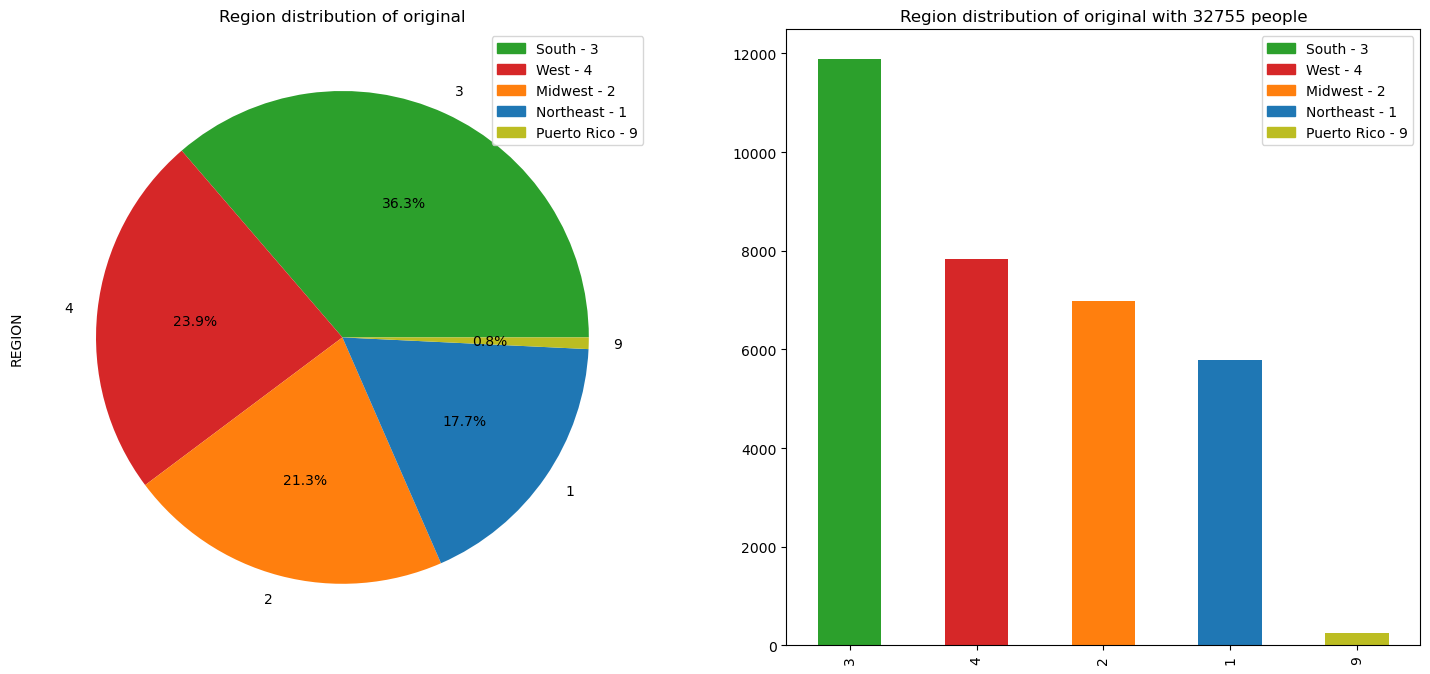

In [7]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
region_label_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West', 9: 'Puerto Rico'}
piechart("Region distribution of original", original, axs[0], 'REGION', region_label_mapping, legendOn)
barplotForCounts(f"Region distribution of original with {original.shape[0]} people", original, axs[1], 'REGION', region_label_mapping, legendOn)
plt.show()

I computed the average income for the entire population and for different protected subpopulations (different sexes, different races). I also computed the proportion of people making > 50k a year for the entire population. 

In [8]:
def average_income(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return np.mean(df['PINCP'])

def proportion_above_50k(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return df.loc[df['PINCP'] > 50000].shape[0]/df.shape[0]

print(f"Average income in original: ${average_income(original):.2f}")
print(f"Proportion of people making > 50K a year in original: {proportion_above_50k(original):.3%}")

Average income in original: $45093.63
Proportion of people making > 50K a year in original: 23.938%


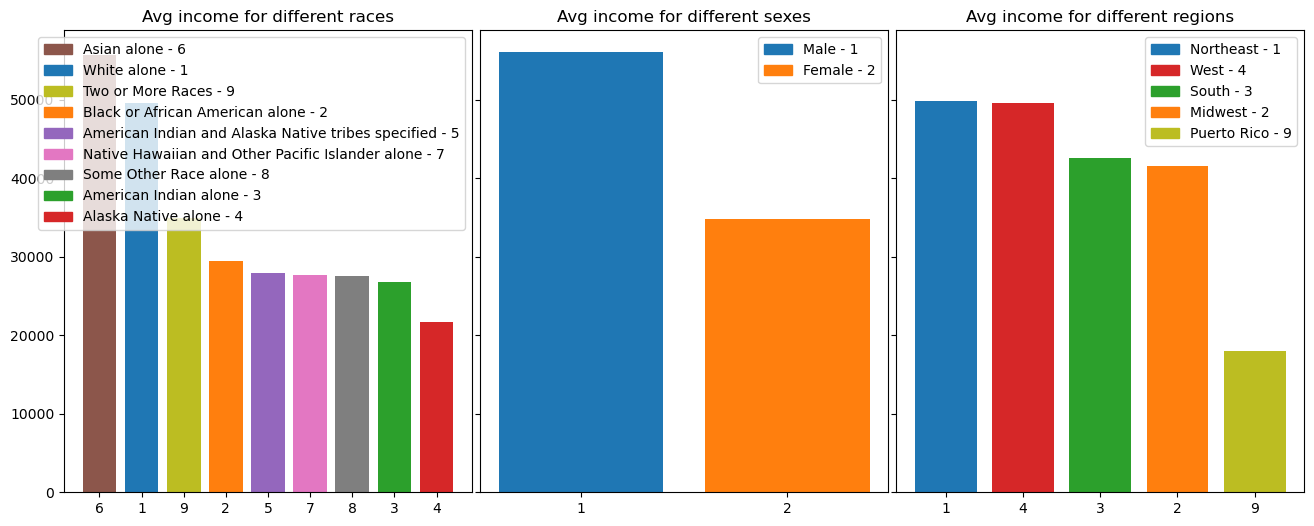

In [9]:
def barplotForAvg(title, df, column, ax, label_mapping, legendOn=False):
    averages = df.pivot_table(values='PINCP', index=column, aggfunc='mean').sort_values(ascending=False, by='PINCP')
    labels = list(averages.index.values)
    colors = [colors_mapping[l] for l in labels]
    #averages.plot.bar(ax=ax, color=colors)
    ax.bar([str(num) for num in averages.index.values], averages['PINCP'].values, color=colors)
    #ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #ax.axhline(avg_income, color='red', linewidth=2)
    if legendOn:
        handles = [plt.Rectangle((0,0),1,1, color=colors_mapping[label]) for label in labels]
        ax.legend(handles, [f"{label_mapping[l]} - {l}" for l in labels])
    else:
        for i, v in enumerate(averages['PINCP'].values):
            plt.text(i, v*0.5, str(int(round(v,0))), ha='center', va='center', rotation=90)
        plt.ylim((0, 70000))
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for different races", original, 'RAC1P', axs[0], race_label_mapping, legendOn)
barplotForAvg("Avg income for different sexes", original, 'SEX', axs[1], sex_label_mapping, legendOn)
barplotForAvg("Avg income for different regions", original, 'REGION', axs[2], region_label_mapping, legendOn)
fig.subplots_adjust(wspace=0.02)
plt.show()


Then, I found a functional dependency (FD) that is satisfied by the data using https://github.com/USEPA/FDTool. I needed to make a python 2.7 environment with conda to run FDTool.

In [10]:
original = original[['RAC1P', 'SEX', 'REGION', 'PINCP', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS','MIL']]
original.to_csv('datasets/original_census.csv',index=False)

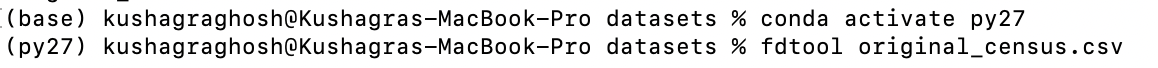

In [11]:
fd_file = open("datasets/original_census.FD_Info.txt", "r")
print(fd_file.read())
fd_file.close()

Table : original_census
Columns : RAC1P, SEX, REGION, PINCP, ST, COW, CIT, NATIVITY, MSP, SCHL, DIS, MIL

Functional Dependencies: 
{ST} -> {REGION}
{CIT} -> {NATIVITY}

Equivalences: 

Keys: 
{RAC1P, SEX, PINCP, ST, COW, CIT, MSP, SCHL, DIS, MIL}

Time (s): 133.7711
Row count: 32755
Attribute count: 12
Number of Equivalences: 0
Number of FDs: 2
Number of FDs checked: 3839


I verified that the FD or DC makes sense and that the data doesn't violate the FD or DC before moving to the next step. 

Given two columns ST (state) and REGION (of the US), the approach I implemented to check for Functional Dependencies to first group by the values of the ST column and use the nunique() method to check number of unique values in REGION for each group in the ST column. If all of the values are 1, that means that there is a unique value for REGION for each each value in ST, which means that columns ST and REGION conform to a functional dependency.

In [12]:
def satisfiesFD(df, col1, col2):
    return df.groupby([col1])[col2].nunique().eq(1).all()
def satisfiesDC(df, col1, val1, col2, val2):
    return df[df[col1] == val1][col2].eq(val2).sum() == 0

print(satisfiesFD(original,'ST','REGION'))
print(satisfiesFD(original,'CIT','NATIVITY'))

True
True


### Synthetic Data Generation (without constraints)

Then, I generated synthetic data (with a machine learning model), which changes the values of the tuple but maintains the same number of tuples. With my new synthetic adult data, I will check how many violations of the Functional Dependencies and Denial Constraints I find, and how the various marginal distributions for income based on race, gender, education, and more is affected.

In [13]:
%%capture
pip install sdv

For the first synthetic data being generated from the original data (original), I decided to only use metadata about the numerical or categorical type of each attribute, and chose to specifically omit constraints such as the FixedConstraints (which is as close to Functional Dependencies or Denial Constraints as the SDV package offers). I will add these constraints in my second synthetic data generator that use the original data (original) and several constraints (FD or DC) that I observed in the data from above.

In [14]:
from sdv.metadata import SingleTableMetadata

def update_column(metadata, column_type, *args):
    for col in args:
        metadata.update_column(
            column_name=col,
            sdtype='categorical'
        )
        
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=original)
update_column(metadata, 'categorical', 'RAC1P', 'SEX', 'REGION', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS', 'MIL')

I experimented with using several synthetic data generators (from the Synthetic Data Vault package found at https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers) using various Copulas and Deep Learning based models. Finally, I used the FAST ML Preset synthesizer from https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/fast-ml-preset to generate new synthetic data from the original data (adult_data) due to its quicker runtime and more accurate distributions compared to the original dataset. 

Generating synthetic data (version 1) without constraints and then downloading it as CSV to be eventually cleaned with Holoclean and Muse.

In [15]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(original)
synthetic_data = synthesizer.sample(num_rows=2100)
display(synthetic_data)

synthetic_data[synthetic_data["RAC1P"] == 7]

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,6,1,4,-8500.000000,35,1.0,1,1,1.0,21.0,2,4.0
2096,2,2,2,84608.504877,6,1.0,1,2,1.0,20.0,2,4.0
2097,1,1,4,13482.011731,6,1.0,1,1,5.0,20.0,2,4.0
2098,1,1,4,59692.970716,51,NaN,1,1,4.0,4.0,2,4.0


,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
1637,7,2,3,67594.678787,48,NaN,1,1,6.0,18.0,1,4.0
2061,7,1,2,NaN,39,4.0,1,1,6.0,21.0,2,4.0


Then, I checked if the generated data satisfies the functional dependencies from above. I check if two columns form a FD by comparing the values at both columns for each tuple and checking if one column uniquely determined the other column. 

In [16]:
print("For the functional dependency between ST -> REGION:")
print(f"The original satisfies FD: {satisfiesFD(original,'ST','REGION')}\nThe synthetic_data without constraints satisfies FD: {satisfiesFD(synthetic_data,'ST','REGION')}")

print("\nFor the functional dependency between CIT -> NATIVITY:")
print(f"The original satisfies FD: {satisfiesFD(original,'CIT','NATIVITY')}\nThe synthetic_data satisfies FD: {satisfiesFD(synthetic_data,'CIT','NATIVITY')}")                                                                                            

For the functional dependency between ST -> REGION:
The original satisfies FD: True
The synthetic_data without constraints satisfies FD: False

For the functional dependency between CIT -> NATIVITY:
The original satisfies FD: True
The synthetic_data satisfies FD: False


I also checked how many violations of the FDs are in the data. (i.e., how many pairs of tuples violate it) to quantify how noisy the new synthetic data is. In order to do this, I did a projection on my dataframe to get the relevant columns for the FD, and then I did a self join query with the column in the left side of the FD being equal but the column in the right side of the FD being not equal (for example for Col1 -> Col2, I set the join condition as A.Col1 = B.Col1 and A.Col2 != B.Col2). 

Then I counted how many tuples form a violation the new merged table, and divided this number by the maximum number of ways of joining two tuples together. This number is equal to the maximum number of violations possible in the new merge table, which turns out to be $tuples\space in \space original \space dataframe \choose 2$ . 

In [17]:
import math

def numberOfViolations(df, col1, col2):
    merging_data = df[[col1, col2]]
    num_rows = merging_data.shape[0]
    maxViolations = math.comb(num_rows,2)
    
    merging_data = merging_data.reset_index()
    merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)
    
    result = pd.merge(merging_data, merging_data, how='inner', left_on=[col1], right_on=[col1], suffixes=('_left', '_right'))
    result = result[result['index_left'] > result['index_right']]
    result = result[result[f'{col2}_left'] != result[f'{col2}_right']]
    num_violations = result.shape[0]
    return f"{num_violations} pairs of tuples violate the {col1} -> {col2} FD. The maximum possible violations are {maxViolations}. The percentage is {num_violations/maxViolations:.3%}"

print(numberOfViolations(synthetic_data, 'ST', 'REGION'))
print(numberOfViolations(synthetic_data, 'CIT', 'NATIVITY'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)
/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


68842 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 2203950. The percentage is 3.124%
103106 pairs of tuples violate the CIT -> NATIVITY FD. The maximum possible violations are 2203950. The percentage is 4.678%


In [18]:
synthetic_data.to_csv('datasets/synthetic_data_version_1.csv',index=False)

In [19]:
muse_synthetic_data = synthetic_data
muse_synthetic_data.to_csv('datasets/muse/synthetic_data_version_1.csv',index=False)

### Synthetic Data Generation (with constraints)

I will test my claim about how synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data because they don't fairly represent different protected subpopulations that appear less frequently in the original dataset. I will test this by creating another synthetic data generator with the same metadata but now with a combination of functional dependencies that was not present in the first synthetic data generator (which was called 'synthesizer'). 

I used FixedCombinations (https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes) as a proxy for functional dependencies since FixedCombinations were one of the only constraints that the Synthetic Data Vault (SDV) generators take in that is closest to a FD (since they didn't have a way to explicitly define FDs).

In [20]:
fd = [['ST','REGION'], ['CIT','NATIVITY']]

def FixedCombinationsConstraint(fds):
    constraints = []
    for fd in fds:
        constraint = {
            'constraint_class': 'FixedCombinations',
            'constraint_parameters': {
                'column_names': fd
            }
        }
        constraints.append(constraint)
    return constraints

Generating synthetic data (version 2) with constraints

In [21]:
synthesizer2 = SingleTablePreset(metadata, name='FAST_ML')
synthesizer2.add_constraints(
    constraints=FixedCombinationsConstraint(fd)
)
synthesizer2.fit(original)
synthetic_data2 = synthesizer2.sample(num_rows=original.shape[0])
display(synthetic_data2)

Sampling rows: 100%|███████████████████| 32755/32755 [00:00<00:00, 55848.42it/s]


,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,2,1,1,NaN,34,NaN,1,1,6.0,18.0,2,4.0
1,8,2,4,38393.426584,6,1.0,1,1,NaN,18.0,2,4.0
2,1,2,4,-8500.000000,56,1.0,1,1,1.0,21.0,2,4.0
3,1,1,3,NaN,47,3.0,1,1,1.0,22.0,2,4.0
4,1,1,2,92553.536861,29,1.0,1,1,NaN,21.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,2,4,NaN,6,NaN,1,1,4.0,4.0,2,4.0
32751,1,2,4,NaN,8,NaN,1,1,1.0,18.0,2,4.0
32752,8,2,3,41345.910832,47,1.0,1,1,6.0,20.0,2,4.0
32753,1,2,1,15994.691291,25,3.0,1,1,1.0,22.0,2,4.0


In [22]:
print(f"The synthetic_data2 with constraints satisfies FD from ST -> REGION: {satisfiesFD(synthetic_data2,'ST','REGION')}")
print(f"The synthetic_data2 with constraints satisfies FD from CIT -> NATIVITY: {satisfiesFD(synthetic_data2,'CIT','NATIVITY')}")

The synthetic_data2 with constraints satisfies FD from ST -> REGION: True
The synthetic_data2 with constraints satisfies FD from CIT -> NATIVITY: True


In [23]:
synthetic_data2.to_csv('datasets/synthetic_data_version_2.csv',index=False)

### Holoclean repair on synthetic data without constraints

For the synthetic data without constraints (synthetic_data or 'datasets/synthetic_data_version_1.csv'), I repared the data using Holoclean in HolocleanOnSyntheticACSPersonData.ipynb, and then I retrieved the cleaned data from the PostgreSQL database and put the data into the dataframe holoclean_data using psycopg2.

In [24]:
%%capture
pip install psycopg2

In [25]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe
holoclean_data = pd.read_sql("SELECT * FROM synthetic_data_version_1_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [26]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,_nan_,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.50607515374,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.85895569899,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,_nan_,9,_nan_,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.54754111301,34,_nan_,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,6,1,4,-8500.0,35,1.0,1,1,1.0,21.0,2,4.0
2096,2,2,2,84608.50487677663,6,1.0,1,2,1.0,20.0,2,4.0
2097,1,1,4,13482.011731247945,6,1.0,1,1,5.0,20.0,2,4.0
2098,1,1,4,59692.97071589308,51,_nan_,1,1,4.0,4.0,2,4.0


As you can see from the Holoclean dataframe above, the \_nan\_ values need to be replaced by NaN, and I also need to change the column types from Varchar to Integer or Float.

In [27]:
print(holoclean_data.isna().sum().sum())
print(holoclean_data.eq('_nan_').sum().sum())
holoclean_data = holoclean_data.replace('_nan_', np.nan)

def make_col_int(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        df[col] = df[col].astype(int)
def make_col_float(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        
make_col_int(holoclean_data, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(holoclean_data, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')

0
1216


In [28]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,6,1,4,-8500.000000,35,1.0,1,1,1.0,21.0,2,4.0
2096,2,2,2,84608.504877,6,1.0,1,2,1.0,20.0,2,4.0
2097,1,1,4,13482.011731,6,1.0,1,1,5.0,20.0,2,4.0
2098,1,1,4,59692.970716,51,NaN,1,1,4.0,4.0,2,4.0


To check how many tuples were changed using the HoloClean repair process on the synthetic data without constraints:

In [29]:
comparing = muse_synthetic_data.compare(holoclean_data, keep_equal=True)
display(comparing)
print(f"{comparing.shape[0]} tuples (rows) out of a total {synthetic_data.shape[0]} were changed")

num_cells_changed = 0
for i in range(0, len(comparing.columns), 2):
    num_cells_changed += comparing.isna().eq(True).sum().loc[comparing.columns[i]] - comparing.isna().eq(True).sum().loc[comparing.columns[i+1]]
print(f"{num_cells_changed} cells were changed from NaN to values")

# print("Synthetic Data without constraints: Row 996")
# display(muse_synthetic_data.iloc[996])
# print("Holoclean Data: Row 996")
# display(holoclean_data.iloc[996])

COW        MSP        SCHL        MIL      
     self other self other  self other self other
13    1.0   1.0  6.0   6.0  14.0  14.0  NaN   4.0
16    NaN   1.0  5.0   5.0  22.0  22.0  4.0   4.0
27    NaN   1.0  NaN   1.0  12.0  12.0  4.0   4.0
28    NaN   1.0  6.0   6.0  11.0  11.0  NaN   4.0
30    NaN   1.0  NaN   6.0   1.0   1.0  4.0   4.0
...   ...   ...  ...   ...   ...   ...  ...   ...
2059  NaN   NaN  6.0   6.0  18.0  18.0  NaN   4.0
2072  3.0   3.0  NaN   1.0  17.0  17.0  4.0   4.0
2075  NaN   NaN  1.0   1.0  19.0  19.0  NaN   4.0
2077  NaN   1.0  1.0   1.0  16.0  16.0  4.0   4.0
2087  NaN   NaN  6.0   6.0  19.0  19.0  NaN   4.0

[412 rows x 8 columns]

412 tuples (rows) out of a total 2100 were changed
481 cells were changed from NaN to values


Since the Holoclean and other repair algorithms are probabilistic and not deterministic, we need to find the number of violations before repairing (after synthetic data generation) and after cleaning/repair (for Holoclean and Muse). For example in HoloClean, if the number of violations for functional dependencies is beyond some percentage in the data, it won't do anything to repair, so we should know if Holoclean gave up and did nothing.

In [30]:
print(numberOfViolations(synthetic_data, 'ST', 'REGION'))
print(numberOfViolations(holoclean_data, 'ST', 'REGION'))

68842 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 2203950. The percentage is 3.124%
68842 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 2203950. The percentage is 3.124%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)
/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


In [31]:
print(numberOfViolations(synthetic_data, 'CIT', 'NATIVITY'))
print(numberOfViolations(holoclean_data, 'CIT', 'NATIVITY'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


103106 pairs of tuples violate the CIT -> NATIVITY FD. The maximum possible violations are 2203950. The percentage is 4.678%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


103106 pairs of tuples violate the CIT -> NATIVITY FD. The maximum possible violations are 2203950. The percentage is 4.678%


In [32]:
holoclean_data.to_csv('datasets/holoclean_data.csv',index=False)

The average income (the actual number) of people with disability and without disability for the original, synthetic and post-repair data: 

In [33]:
print(f"Average income for people with a disability in original: ${average_income(original[original['DIS']==1]):.2f}")
print(f"Average income for people without a disability in original: ${average_income(original[original['DIS']==2]):.2f}")
print(f"Average income for people with a disability in synthetic_data: ${average_income(synthetic_data[synthetic_data['DIS']==1]):.2f}")
print(f"Average income for people without a disability in synthetic_data: ${average_income(synthetic_data[synthetic_data['DIS']==2]):.2f}")
print(f"Average income for people with a disability in holoclean_data: ${average_income(holoclean_data[holoclean_data['DIS']==1]):.2f}")
print(f"Average income for people without a disability in holoclean_data: ${average_income(holoclean_data[holoclean_data['DIS']==2]):.2f}")

Average income for people with a disability in original: $28672.16
Average income for people without a disability in original: $48608.09
Average income for people with a disability in synthetic_data: $35757.38
Average income for people without a disability in synthetic_data: $52581.60
Average income for people with a disability in holoclean_data: $35757.38
Average income for people without a disability in holoclean_data: $52581.60


The average income (the actual number) of people with sex male and sex female for the original, synthetic and post-repair data: 

In [34]:
print(f"Average income for people with sex male in original: ${average_income(original[original['SEX']==1]):.2f}")
print(f"Average income for people with sex female in original: ${average_income(original[original['SEX']==2]):.2f}")
print(f"Average income for people with sex male in synthetic_data: ${average_income(synthetic_data[synthetic_data['SEX']==1]):.2f}")
print(f"Average income for people with sex female in synthetic_data: ${average_income(synthetic_data[synthetic_data['SEX']==2]):.2f}")
print(f"Average income for people with sex male in holoclean_data: ${average_income(holoclean_data[holoclean_data['SEX']==1]):.2f}")
print(f"Average income for people with sex female in holoclean_data: ${average_income(holoclean_data[holoclean_data['SEX']==2]):.2f}")

Average income for people with sex male in original: $56017.13
Average income for people with sex female in original: $34852.28
Average income for people with sex male in synthetic_data: $55046.35
Average income for people with sex female in synthetic_data: $48470.36
Average income for people with sex male in holoclean_data: $55046.35
Average income for people with sex female in holoclean_data: $48470.36


### Multiple Semantics (MUSE) repair

Using the MUSE repair process on the synthetic data without constraints:

#### Step Semantics:

In [36]:
def make_col_int(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        df[col] = df[col].astype(int)
def make_col_float(df, *args):
    for col in args:
        df[col] = df[col].astype(float)

import pandas as pd

muse_data_step = pd.read_csv('datasets/muse/muse_data_step.csv')
muse_data_step.replace('None', float('nan'), inplace=True)
make_col_int(muse_data_step, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(muse_data_step, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')
display(muse_data_step)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
1,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
2,4,2,3,35818.371839,12,NaN,1,1,NaN,9.0,2,4.0
3,1,1,3,67608.023366,36,1.0,1,1,NaN,14.0,2,2.0
4,1,2,4,-8500.000000,45,1.0,1,1,4.0,18.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
788,1,2,4,85493.604974,37,NaN,1,1,1.0,18.0,2,4.0
789,2,2,3,91413.822235,6,3.0,1,1,1.0,16.0,2,4.0
790,6,1,4,-8500.000000,35,1.0,1,1,1.0,21.0,2,4.0
791,1,1,4,59692.970716,51,NaN,1,1,4.0,4.0,2,4.0


In [37]:
print(f"The muse_data_step satisfies FD from ST -> REGION: {satisfiesFD(muse_data_step,'ST','REGION')}")

The muse_data_step satisfies FD from ST -> REGION: True


In [38]:
print(numberOfViolations(muse_synthetic_data, 'ST', 'REGION'))
print(numberOfViolations(muse_data_step, 'ST', 'REGION'))

68842 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 2203950. The percentage is 3.124%
0 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 314028. The percentage is 0.000%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)
/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


In [39]:
print(numberOfViolations(muse_synthetic_data, 'CIT', 'NATIVITY'))
print(numberOfViolations(muse_data_step, 'CIT', 'NATIVITY'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


103106 pairs of tuples violate the CIT -> NATIVITY FD. The maximum possible violations are 2203950. The percentage is 4.678%
13324 pairs of tuples violate the CIT -> NATIVITY FD. The maximum possible violations are 314028. The percentage is 4.243%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_31036/20059087.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


The average income (the actual number) of people with disability and without disability for the original, synthetic and post-repair data: 

In [40]:
print(f"Average income for people with a disability in original: ${average_income(original[original['DIS']==1]):.2f}")
print(f"Average income for people without a disability in original: ${average_income(original[original['DIS']==2]):.2f}")
print(f"Average income for people with a disability in synthetic_data: ${average_income(synthetic_data[synthetic_data['DIS']==1]):.2f}")
print(f"Average income for people without a disability in synthetic_data: ${average_income(synthetic_data[synthetic_data['DIS']==2]):.2f}")
print(f"Average income for people with a disability in muse_data_step: ${average_income(muse_data_step[muse_data_step['DIS']==1]):.2f}")
print(f"Average income for people without a disability in muse_data_step: ${average_income(muse_data_step[muse_data_step['DIS']==2]):.2f}")

Average income for people with a disability in original: $28672.16
Average income for people without a disability in original: $48608.09
Average income for people with a disability in synthetic_data: $35757.38
Average income for people without a disability in synthetic_data: $52581.60
Average income for people with a disability in muse_data_step: $32628.93
Average income for people without a disability in muse_data_step: $53208.08


The average income (the actual number) of people with sex male and sex female for the original, synthetic and post-repair data: 

In [41]:
print(f"Average income for people with sex male in original: ${average_income(original[original['SEX']==1]):.2f}")
print(f"Average income for people with sex female in original: ${average_income(original[original['SEX']==2]):.2f}")
print(f"Average income for people with sex male in synthetic_data: ${average_income(synthetic_data[synthetic_data['SEX']==1]):.2f}")
print(f"Average income for people with sex female in synthetic_data: ${average_income(synthetic_data[synthetic_data['SEX']==2]):.2f}")
print(f"Average income for people with sex male in muse_data_step: ${average_income(muse_data_step[muse_data_step['SEX']==1]):.2f}")
print(f"Average income for people with sex female in muse_data_step: ${average_income(muse_data_step[muse_data_step['SEX']==2]):.2f}")

Average income for people with sex male in original: $56017.13
Average income for people with sex female in original: $34852.28
Average income for people with sex male in synthetic_data: $55046.35
Average income for people with sex female in synthetic_data: $48470.36
Average income for people with sex male in muse_data_step: $54727.36
Average income for people with sex female in muse_data_step: $49233.38


#### End Semantics:

In [59]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="cr",
    user="postgres",
    password="postgres"
)

# Execute an SQL query and create a dataframe hospital_repaired
muse_data_end = pd.read_sql("SELECT * FROM synthetic_data_version_1", conn).iloc[1:]
muse_data_end.drop(muse_data_end.index[0])

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [60]:
make_col_int(muse_data_end, 'rac1p', 'sex', 'region', 'st', 'cit', 'nativity', 'dis')
make_col_float(muse_data_end, 'pincp', 'cow', 'msp', 'schl', 'mil')
display(muse_data_end)

,rac1p,sex,region,pincp,st,cow,cit,nativity,msp,schl,dis,mil
1,6,2,3,-2615.090606,48,NaN,1,1,5.0,22.0,2,4.0
2,1,2,9,NaN,56,1.0,1,1,NaN,22.0,2,4.0
3,2,2,3,28787.553763,53,4.0,1,1,4.0,18.0,2,4.0
4,9,2,3,NaN,12,1.0,4,1,1.0,16.0,2,NaN
5,9,2,3,-8500.000000,39,1.0,1,1,4.0,NaN,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,2,1,-8500.000000,50,NaN,1,1,6.0,1.0,2,1.0
997,1,1,4,-6025.412259,39,1.0,1,1,1.0,21.0,2,4.0
998,8,2,3,NaN,37,1.0,4,1,6.0,16.0,2,4.0
999,1,1,4,1998.838416,55,1.0,1,1,6.0,14.0,2,4.0


In [61]:
muse_data_end.to_csv('datasets/muse/muse_data_end.csv',index=False)

#### Stage Semantics:

In [100]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="cr",
    user="postgres",
    password="postgres"
)

# Execute an SQL query and create a dataframe hospital_repaired
muse_data_stage = pd.read_sql("SELECT * FROM synthetic_data_version_1", conn).iloc[1:]
muse_data_stage.drop(muse_data_stage.index[0])

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


IndexError: index 0 is out of bounds for axis 0 with size 0

In [101]:
make_col_int(muse_data_stage, 'rac1p', 'sex', 'region', 'st', 'cit', 'nativity', 'dis')
make_col_float(muse_data_stage, 'pincp', 'cow', 'msp', 'schl', 'mil')
display(muse_data_stage)

,rac1p,sex,region,pincp,st,cow,cit,nativity,msp,schl,dis,mil


In [88]:
muse_data_stage.to_csv('datasets/muse/muse_data_stage.csv',index=False)

### Experiment (injecting errors for Holoclean)

Experiment where I inject errors to my database and take Holoclean to show that Data Cleaning systems do not maintain representations by default.

In [69]:
def replace_vals(val, possible_vals):
    new_val = val
    while new_val == val:
        new_val = np.random.choice(possible_vals)
    return new_val

def insert_errors(df, alpha, column):
    df_copy = df.copy()
    random_sample = df_copy.sample(frac=alpha)
    print(df_copy[column].unique())
    df_copy.loc[random_sample.index, column] = df_copy.loc[random_sample.index, column].apply(lambda val: replace_vals(val, df_copy[column].unique()))
    return df_copy

experiment_data = insert_errors(original, 0.0001, 'REGION')
display(original.compare(experiment_data))
experiment_data2 = insert_errors(experiment_data, 0.0001, 'NATIVITY')
display(original.compare(experiment_data2))

print(satisfiesFD(experiment_data2,'ST','REGION'))
print(satisfiesFD(experiment_data2,'CIT','NATIVITY'))

[3 4 1 2 9]


REGION      
        self other
17676    4.0   1.0
28427    3.0   1.0
30953    4.0   3.0

[1 2]


REGION       NATIVITY      
        self other     self other
3528     NaN   NaN      1.0   2.0
14610    NaN   NaN      1.0   2.0
17676    4.0   1.0      NaN   NaN
26003    NaN   NaN      2.0   1.0
28427    3.0   1.0      NaN   NaN
30953    4.0   3.0      NaN   NaN

False
False


In [70]:
print(numberOfViolations(original, 'ST', 'REGION'))
print(numberOfViolations(experiment_data2, 'ST', 'REGION'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_76309/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


0 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.000%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_76309/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


3669 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.001%


In [71]:
experiment_data2.to_csv('datasets/experiment_data.csv',index=False)

In [72]:
experiment_data2.compare(original)

REGION       NATIVITY      
        self other     self other
3528     NaN   NaN      2.0   1.0
14610    NaN   NaN      2.0   1.0
17676    1.0   4.0      NaN   NaN
26003    NaN   NaN      1.0   2.0
28427    1.0   3.0      NaN   NaN
30953    3.0   4.0      NaN   NaN

In [75]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_experiment_data = pd.read_sql("SELECT * FROM experiment_data_repaired", conn).iloc[:, 1:]

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [76]:
display(holoclean_experiment_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,3,450.0,1,1.0,1,1,6.0,16.0,2,4.0
1,1,1,3,0.0,1,1.0,1,1,4.0,12.0,2,4.0
2,2,1,3,1000.0,1,1.0,1,1,6.0,16.0,2,4.0
3,1,1,3,0.0,1,_nan_,1,1,3.0,13.0,2,4.0
4,1,2,3,0.0,1,_nan_,1,1,6.0,6.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,1,9,_nan_,72,_nan_,2,1,_nan_,8.0,2,4.0
32751,9,2,9,229800.0,72,1.0,2,1,4.0,23.0,2,4.0
32752,9,2,9,960.0,72,_nan_,2,1,3.0,1.0,1,4.0
32753,2,2,9,_nan_,72,_nan_,2,1,_nan_,4.0,2,4.0


In [77]:
print(holoclean_experiment_data.isna().sum().sum())
print(holoclean_experiment_data.eq('_nan_').sum().sum())
holoclean_experiment_data = holoclean_experiment_data.replace('_nan_', np.nan)
        
make_col_int(holoclean_experiment_data, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(holoclean_experiment_data, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')

0
25597


In [78]:
display(holoclean_experiment_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,3,450.0,1,1.0,1,1,6.0,16.0,2,4.0
1,1,1,3,0.0,1,1.0,1,1,4.0,12.0,2,4.0
2,2,1,3,1000.0,1,1.0,1,1,6.0,16.0,2,4.0
3,1,1,3,0.0,1,NaN,1,1,3.0,13.0,2,4.0
4,1,2,3,0.0,1,NaN,1,1,6.0,6.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,1,9,NaN,72,NaN,2,1,NaN,8.0,2,4.0
32751,9,2,9,229800.0,72,1.0,2,1,4.0,23.0,2,4.0
32752,9,2,9,960.0,72,NaN,2,1,3.0,1.0,1,4.0
32753,2,2,9,NaN,72,NaN,2,1,NaN,4.0,2,4.0


To check how many tuples were changed using the HoloClean repair process on the original data with random changes:

In [79]:
comparing = experiment_data2.compare(holoclean_experiment_data)
display(comparing)
#print(f"{round(comparing.isna().eq(False).sum().sum()/2)} cells were changed")
print(f"{comparing.shape[0]} tuples (rows) out of a total {synthetic_data.shape[0]} were changed")

CIT        MIL      
      self other self other
42     NaN   NaN  NaN   4.0
48     NaN   NaN  NaN   4.0
51     NaN   NaN  NaN   4.0
52     NaN   NaN  NaN   4.0
54     NaN   NaN  NaN   4.0
...    ...   ...  ...   ...
32744  NaN   NaN  NaN   4.0
32747  NaN   NaN  NaN   4.0
32750  NaN   NaN  NaN   4.0
32751  1.0   2.0  NaN   NaN
32753  NaN   NaN  NaN   4.0

[5002 rows x 4 columns]

5002 tuples (rows) out of a total 32755 were changed


Since the Holoclean and other repair algorithms are probabilistic and not deterministic, we need to find the number of violations before repairing (after synthetic data generation) and after cleaning/repair (for Holoclean and Muse). For example in HoloClean, if the number of violations for functional dependencies is beyond some percentage in the data, it won't do anything to repair, so we should know if Holoclean gave up and did nothing.

In [80]:
print(numberOfViolations(experiment_data2, 'ST', 'REGION'))
print(numberOfViolations(holoclean_experiment_data, 'ST', 'REGION'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_76309/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


3669 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.001%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_76309/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


3669 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.001%


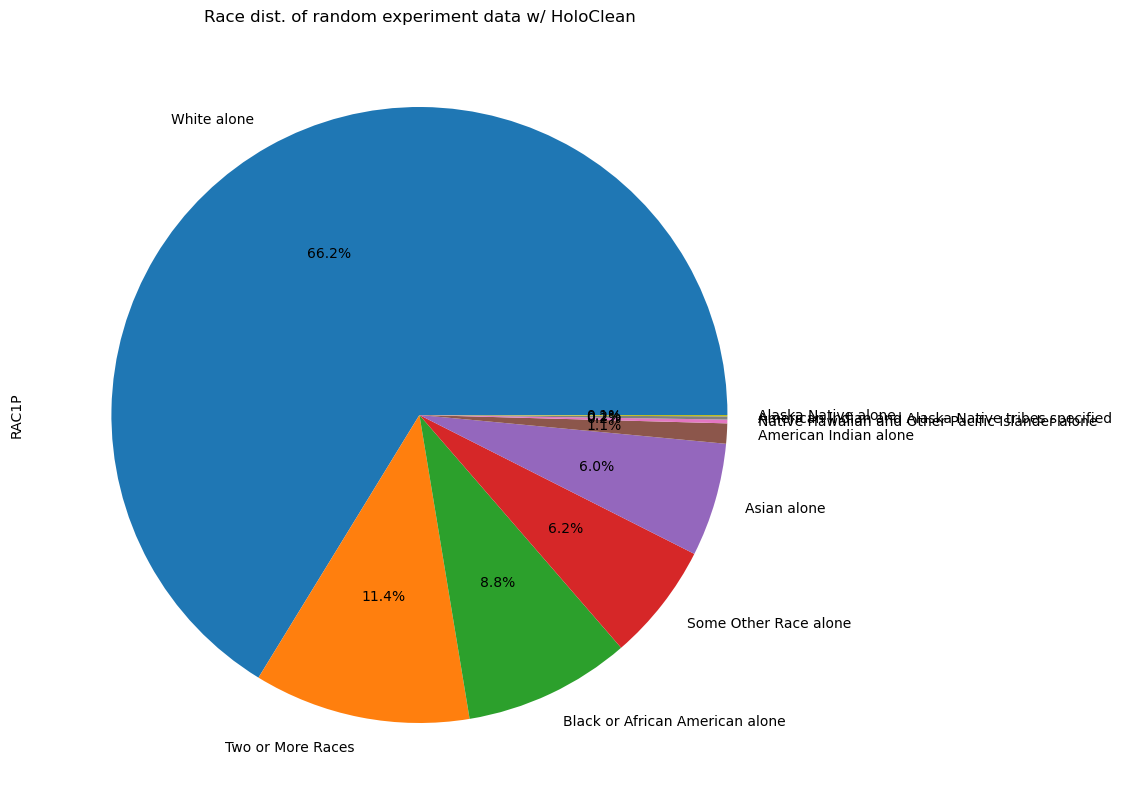

In [64]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race dist. of random experiment data w/ HoloClean", holoclean_experiment_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-experiment-holoclean.png', bbox_inches='tight', dpi=300)

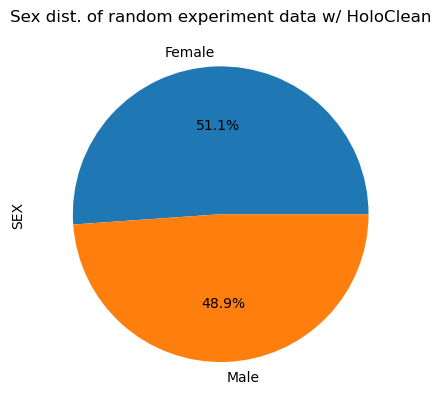

In [65]:
fig, axs = plt.subplots(1,1)
piechart("Sex dist. of random experiment data w/ HoloClean", holoclean_experiment_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-experiment-holoclean.png', bbox_inches='tight', dpi=300)

NameError: name 'holoclean_experiment_data' is not defined

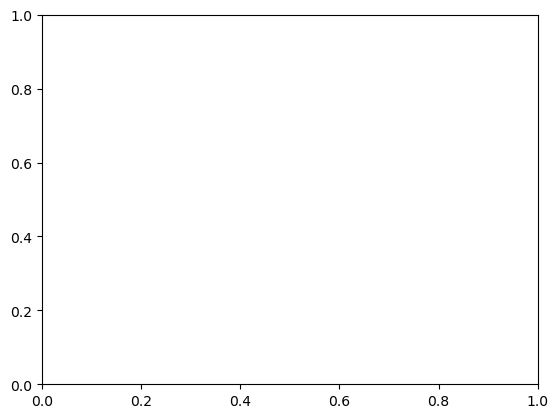

In [115]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for random experiment data w/ HoloClean", holoclean_experiment_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/income-race-experiment-holoclean.png', bbox_inches='tight', dpi=300)

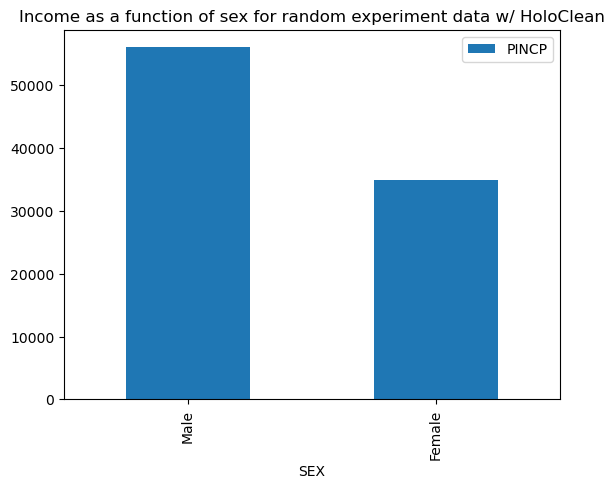

In [67]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for random experiment data w/ HoloClean", holoclean_experiment_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-experiment-holoclean.png', bbox_inches='tight', dpi=300)

### Legends

First, I generated the legend for race, sex, and disability. The colors and numbers labels are consistent for each cateogry for each plot.

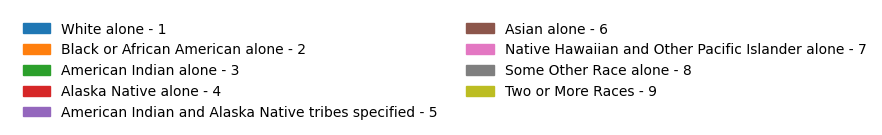

In [42]:
def legend(ax, column, label_mapping):
    averages = original.pivot_table(values='PINCP', index=column, aggfunc='mean')
    labels = list(averages.index.values)
    colors = [colors_mapping[l] for l in labels]
    handles = [plt.Rectangle((0,0),1,1, color=colors_mapping[label]) for label in labels]
    averages = original.pivot_table(values='PINCP', index=column, aggfunc='mean')
    labels = list(averages.index.values)
    colors = [colors_mapping[l] for l in labels]
    handles = [plt.Rectangle((0,0),1,1, color=colors_mapping[label]) for label in labels]
    labels = [f"{label_mapping[l]} - {l}" for l in labels]
    num_columns = 2
    legend = ax.legend(handles, labels, loc='upper left', framealpha=1, frameon=False, ncol=num_columns)
    legend.set_in_layout(True)
    ax.axis('off')
    export_legend(legend, column)

def export_legend(legend, column):
    fig = legend.figure
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig_width, fig_height = bbox.width, bbox.height
    fig.set_size_inches(fig_width, fig_height)
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"plots/legends/{column}-legend.png", dpi="figure", bbox_inches=bbox)

fig, axs = plt.subplots(1,1)
legend(axs, 'RAC1P', race_label_mapping)

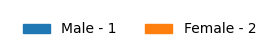

In [43]:
fig, axs = plt.subplots(1,1)
legend(axs, 'SEX', sex_label_mapping)

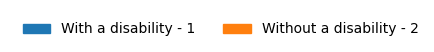

In [44]:
dis_label_mapping = {1: 'With a disability', 2: 'Without a disability'}

fig, axs = plt.subplots(1,1)
legend(axs, 'DIS', dis_label_mapping)

Then, I generated the following __pie charts__: race-original, race-synthetic-without-constraints, race-synthetic-with-constraints, race-holoclean, race-muse, sex-original, sex-synthetic-without-constraints, sex-synthetic-with-constraints, sex-holoclean, and sex-muse.


I also generated the following __bar graphs__: income-race-original, income-race-synthetic-without-constraints, income-race-synthetic-with-constraints, income-race-holoclean, income-race-muse, income-sex-original, income-sex-synthetic-without-constraints, income-sex-synthetic-with-constraints, income-sex-holoclean, income-sex-muse

### Plots for original

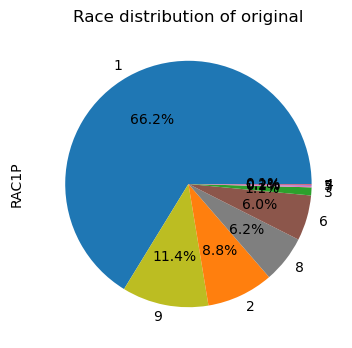

In [45]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race distribution of original", original, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/original/race-original.png', bbox_inches='tight', dpi=300)

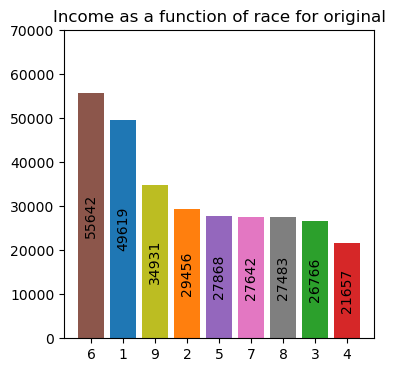

In [46]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a function of race for original", original, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/original/income-race-original.png', bbox_inches='tight', dpi=300)

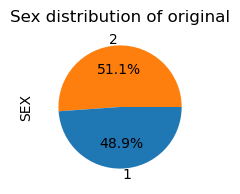

In [47]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex distribution of original", original, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/original/sex-original.png', bbox_inches='tight', dpi=300)

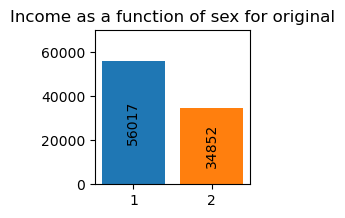

In [48]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of sex for original", original, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/original/income-sex-original.png', bbox_inches='tight', dpi=300)

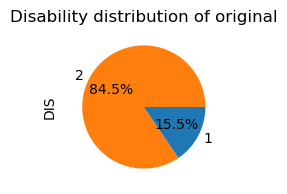

In [49]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability distribution of original", original, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/original/disability-original.png', bbox_inches='tight', dpi=300)

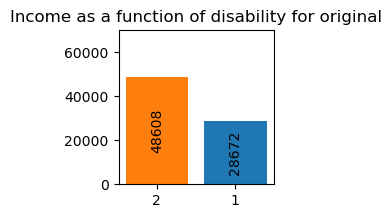

In [50]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of disability for original", original, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/original/income-disability-original.png', bbox_inches='tight', dpi=300)

### Plots of synthetic data without constraints

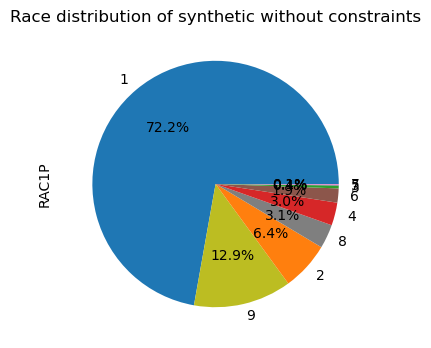

In [51]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race distribution of synthetic without constraints", synthetic_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/synthetic-without-constraints/race-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

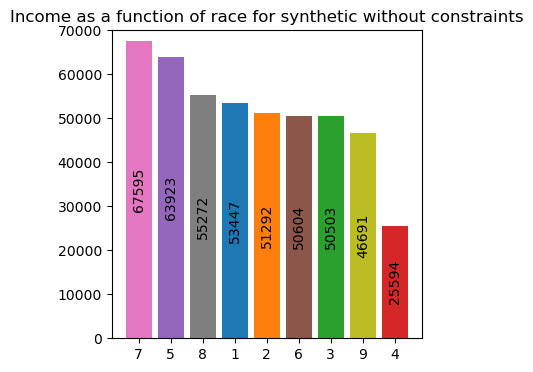

In [52]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a function of race for synthetic without constraints", synthetic_data, 'RAC1P', axs, race_label_mapping)

plt.show()
fig.savefig('plots/synthetic-without-constraints/income-race-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

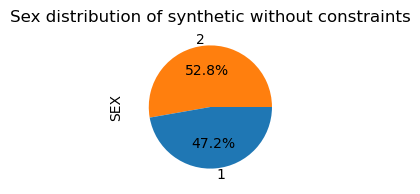

In [53]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex distribution of synthetic without constraints", synthetic_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/synthetic-without-constraints/sex-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

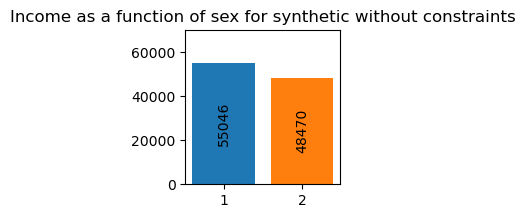

In [54]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of sex for synthetic without constraints", synthetic_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/synthetic-without-constraints/income-sex-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

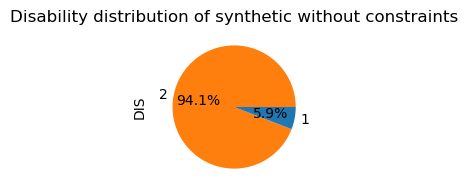

In [55]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability distribution of synthetic without constraints", synthetic_data, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/synthetic-without-constraints/disability-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

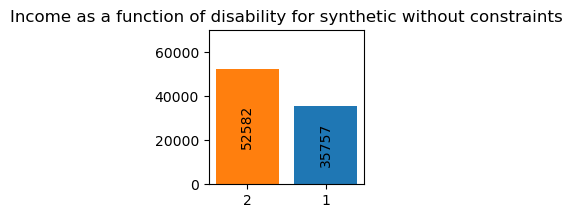

In [56]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of disability for synthetic without constraints", synthetic_data, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/synthetic-without-constraints/income-disability-synthetic-without-constraints.png', bbox_inches='tight', dpi=300)

### Plots for synthetic data with constraints

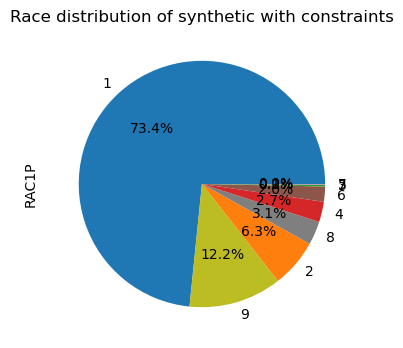

In [57]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race distribution of synthetic with constraints", synthetic_data2, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/race-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

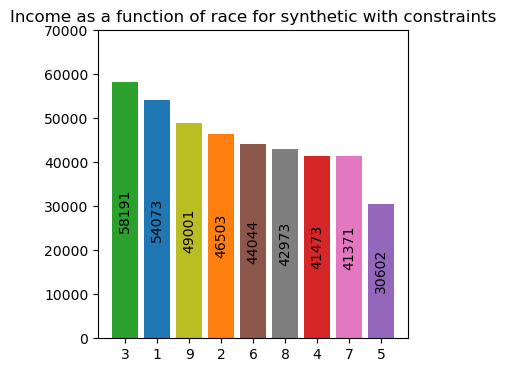

In [58]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a function of race for synthetic with constraints", synthetic_data2, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/income-race-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

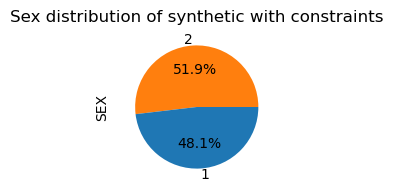

In [59]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex distribution of synthetic with constraints", synthetic_data2, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/sex-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

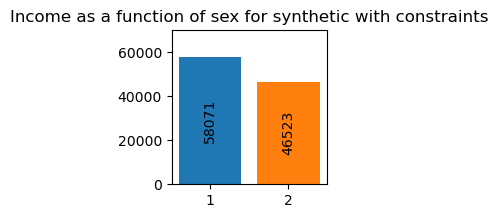

In [60]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of sex for synthetic with constraints", synthetic_data2, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/income-sex-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

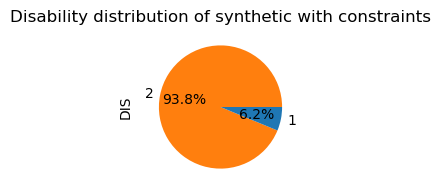

In [61]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability distribution of synthetic with constraints", synthetic_data2, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/disability-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

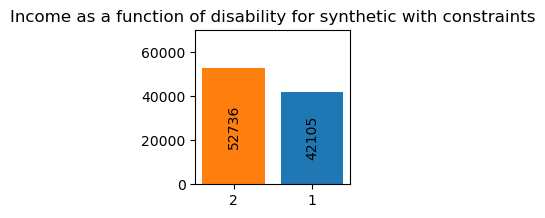

In [62]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of disability for synthetic with constraints", synthetic_data2, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/synthetic-with-constraints/income-disability-synthetic-with-constraints.png', bbox_inches='tight', dpi=300)

### Plots of synthetic data without constraints cleaned with Holoclean

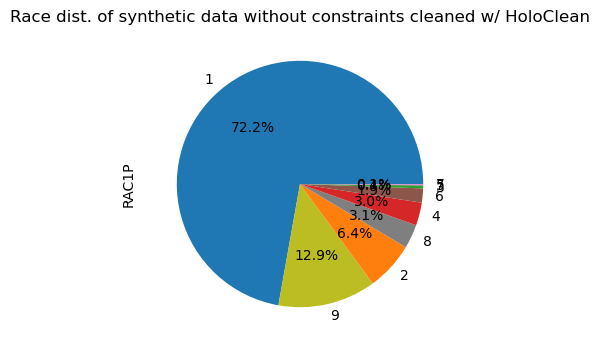

In [63]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/holoclean/race-holoclean.png', bbox_inches='tight', dpi=300)

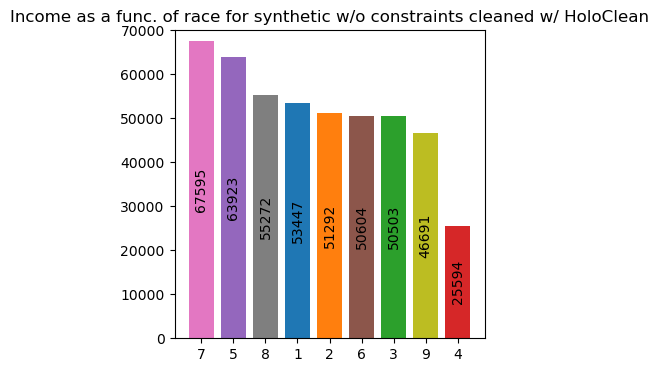

In [64]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a func. of race for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/holoclean/income-race-holoclean.png', bbox_inches='tight', dpi=300)

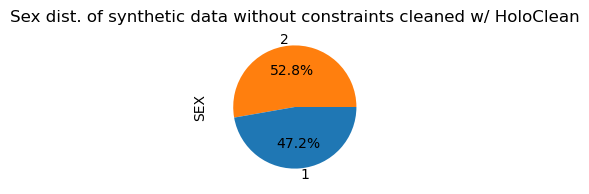

In [65]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/holoclean/sex-holoclean.png', bbox_inches='tight', dpi=300)

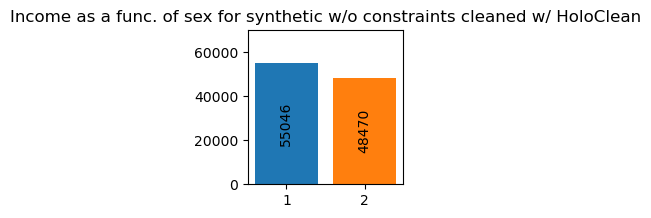

In [66]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a func. of sex for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/holoclean/income-sex-holoclean.png', bbox_inches='tight', dpi=300)

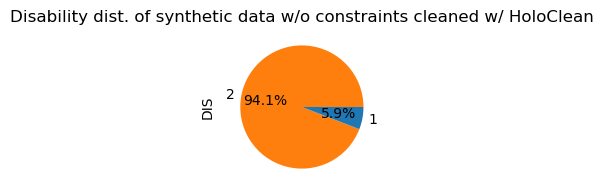

In [67]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability dist. of synthetic data w/o constraints cleaned w/ HoloClean", holoclean_data, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/holoclean/disability-holoclean.png', bbox_inches='tight', dpi=300)

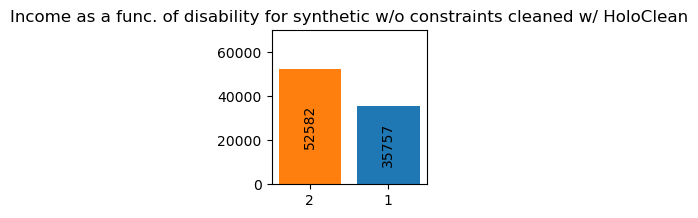

In [68]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a func. of disability for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/holoclean/income-disability-holoclean.png', bbox_inches='tight', dpi=300)

### (For MUSE) Plots for synthetic data without constraints (1000 sampled rows)

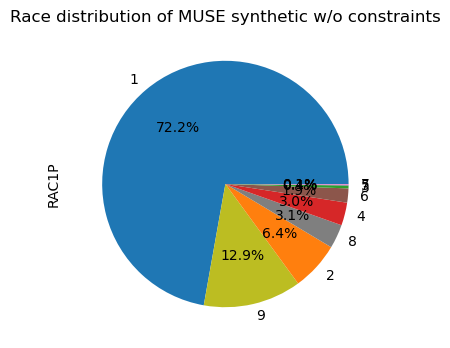

In [69]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race distribution of MUSE synthetic w/o constraints", muse_synthetic_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/muse/race-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

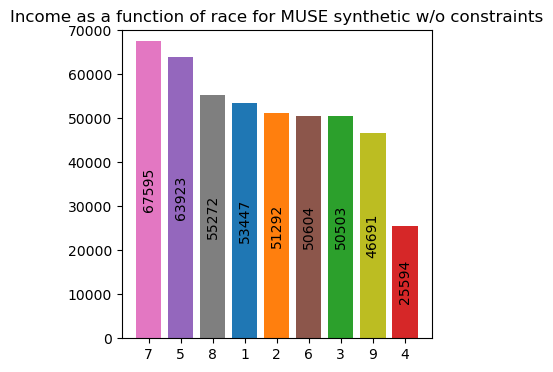

In [70]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a function of race for MUSE synthetic w/o constraints", muse_synthetic_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/muse/income-race-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

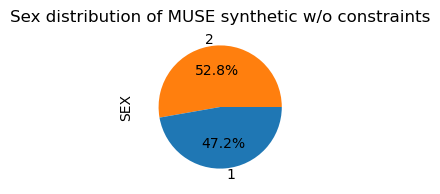

In [71]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex distribution of MUSE synthetic w/o constraints", muse_synthetic_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/muse/sex-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

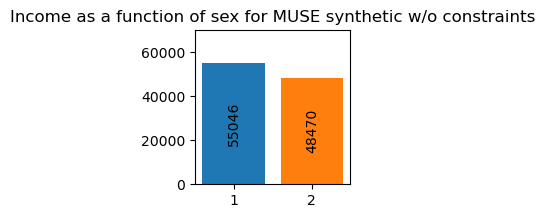

In [72]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of sex for MUSE synthetic w/o constraints", muse_synthetic_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/muse/income-sex-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

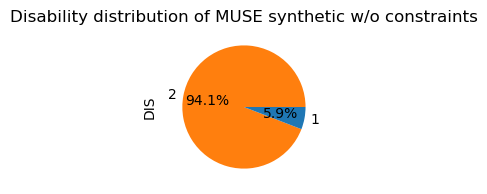

In [73]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability distribution of MUSE synthetic w/o constraints", muse_synthetic_data, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/muse/disability-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

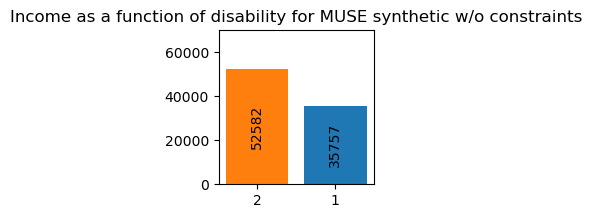

In [74]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a function of disability for MUSE synthetic w/o constraints", muse_synthetic_data, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/muse/income-disability-synthetic-with-constraints-for-muse.png', bbox_inches='tight', dpi=300)

### Plots of synthetic data without constraints cleaned with MUSE

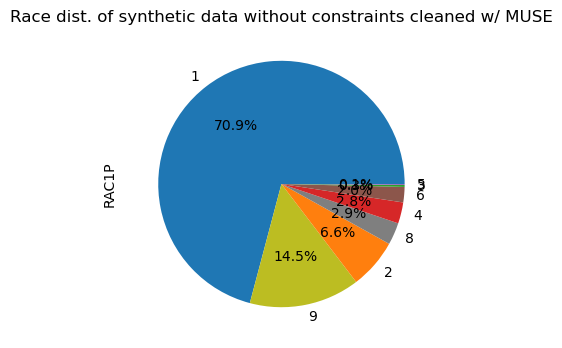

In [75]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
piechart("Race dist. of synthetic data without constraints cleaned w/ MUSE", muse_data_step, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/muse/race-muse-step.png', bbox_inches='tight', dpi=300)

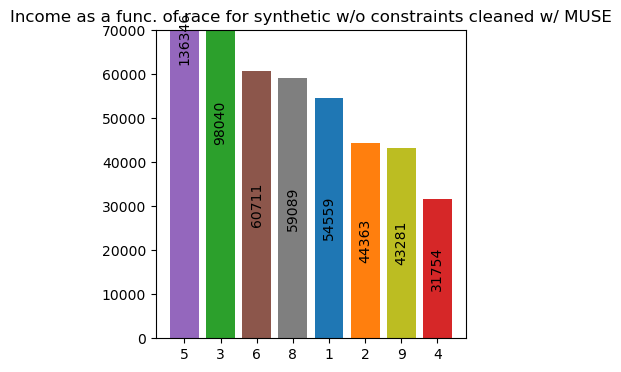

In [79]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
barplotForAvg("Income as a func. of race for synthetic w/o constraints cleaned w/ MUSE", muse_data_step, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/muse/income-race-muse-step.png', bbox_inches='tight', dpi=300)

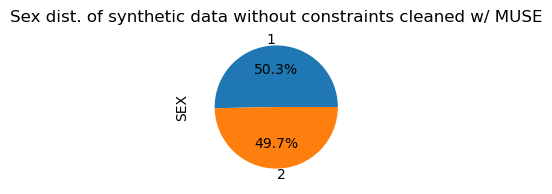

In [80]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Sex dist. of synthetic data without constraints cleaned w/ MUSE", muse_data_step, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/muse/sex-muse-step.png', bbox_inches='tight', dpi=300)

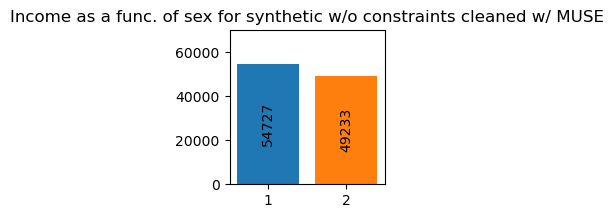

In [81]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a func. of sex for synthetic w/o constraints cleaned w/ MUSE", muse_data_step, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/muse/income-sex-muse-step.png', bbox_inches='tight', dpi=300)

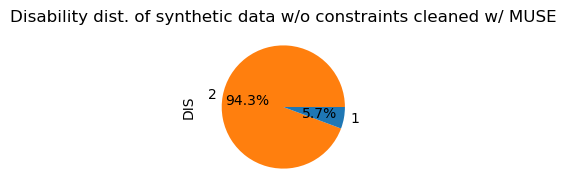

In [82]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
piechart("Disability dist. of synthetic data w/o constraints cleaned w/ MUSE", muse_data_step, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/muse/disability-muse-step.png', bbox_inches='tight', dpi=300)

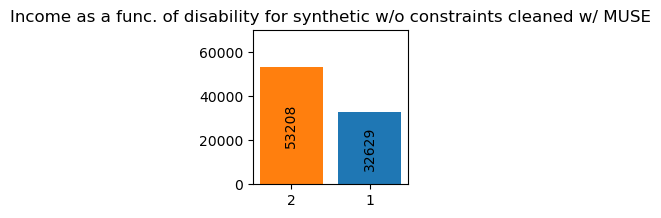

In [83]:
fig, axs = plt.subplots(1,1, figsize=(2,2))
barplotForAvg("Income as a func. of disability for synthetic w/o constraints cleaned w/ MUSE", muse_data_step, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/muse/income-disability-muse-step.png', bbox_inches='tight', dpi=300)

### Tables: Frequency & Avg Income

I created tables for how the numbers (frequency and average income) are changing for the 6 plots with the graphs below it. Each column for every graph. I have 1 set of tables for race, one for gender, one for disability, and these tables will go in my report later.

In [84]:
def frequency_table(dfs, column, dfNames, label_mapping):
    series = []
    for df in dfs:
        #display(df[column].value_counts())
        series.append(df[column].value_counts())
    df = pd.concat(series, axis=1)
    df.columns = dfNames
    df = df.rename(index=label_mapping)
    return df
        
freq_table_race = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'RAC1P', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], race_label_mapping)
freq_table_sex = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'SEX', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], sex_label_mapping)
freq_table_dis = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'DIS', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], dis_label_mapping)

display(freq_table_race)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
White alone,21700,1516,24038,1516,1516,562.0
Two or More Races,3720,270,3996,270,270,115.0
Black or African American alone,2868,134,2078,134,134,52.0
Some Other Race alone,2028,66,1009,66,66,23.0
Asian alone,1951,39,651,39,39,16.0
American Indian alone,346,8,76,8,8,2.0
Native Hawaiian and Other Pacific Islander alone,64,2,17,2,2,NaN
American Indian and Alaska Native tribes specified,55,2,14,2,2,1.0
Alaska Native alone,23,63,876,63,63,22.0


In [85]:
display(freq_table_sex)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
Female,16742,1108,16986,1108,1108,394
Male,16013,992,15769,992,992,399


In [86]:
display(freq_table_dis)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
Without a disability,27676,1977,30716,1977,1977,748
With a disability,5079,123,2039,123,123,45


In [87]:
def avg_income_table(dfs, column, dfNames, label_mapping):
    series = []
    for df in dfs:
        averages = df.pivot_table(values='PINCP', index=column, aggfunc='mean')
        series.append(averages.round(2))
    df = pd.concat(series, axis=1)
    df.columns = dfNames
    df = df.rename(index=label_mapping)
    return df
        
avg_table_race = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'RAC1P', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], race_label_mapping)
avg_table_sex = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'SEX', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], sex_label_mapping)
avg_table_dis = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, muse_synthetic_data, muse_data_step], 'DIS', ['original', 'synthetic_data', 'synthetic_data2', 'holoclean_data', 'muse_synthetic_data', 'muse_data_step'], dis_label_mapping)

display(avg_table_race)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
RAC1P,,,,,,
White alone,49618.61,53446.79,54073.43,53446.79,53446.79,54558.80
Black or African American alone,29455.53,51291.69,46502.94,51291.69,51291.69,44363.04
American Indian alone,26766.04,50502.56,58190.72,50502.56,50502.56,98039.63
Alaska Native alone,21656.88,25593.53,41473.14,25593.53,25593.53,31753.79
American Indian and Alaska Native tribes specified,27867.66,63922.93,30602.36,63922.93,63922.93,136345.86
Asian alone,55641.93,50604.02,44043.57,50604.02,50604.02,60711.08
Native Hawaiian and Other Pacific Islander alone,27642.14,67594.68,41370.53,67594.68,67594.68,NaN
Some Other Race alone,27483.22,55271.91,42972.87,55271.91,55271.91,59088.79
Two or More Races,34931.30,46690.54,49000.56,46690.54,46690.54,43280.93


In [88]:
display(avg_table_sex)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
SEX,,,,,,
Male,56017.13,55046.35,58070.75,55046.35,55046.35,54727.36
Female,34852.28,48470.36,46523.36,48470.36,48470.36,49233.38


In [89]:
display(avg_table_dis)

,original,synthetic_data,synthetic_data2,holoclean_data,muse_synthetic_data,muse_data_step
DIS,,,,,,
With a disability,28672.16,35757.38,42104.98,35757.38,35757.38,32628.93
Without a disability,48608.09,52581.60,52735.90,52581.60,52581.60,53208.08


In [70]:
#The reference to the data, what I did too the data, what FD i used, what is the data generation system I used for synthetic data, how many FD violatoons, distiiultions from the graphs, we need to know the same statistics and number of violations
#Have a section of description of data and data processing
#bib file for references in Overleaf

#Synthetic data generation and blind cleaning --> distributions of interest change, representation of different subpopulation for different subgroups in the data, at least preserve the truthgul original distributions, otherwise, for leaning we are not sending the right thing. Distributon in some view (query answrr) for example income vs gender,race, being truthful to that or not. Distributin change may be ok but ranking is the third type of problem that we want to preserve. 
#Repeat this for disability and age
#Adding the Muse graphs for all of this

#Whether the salary distributions constraints

#Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay

# Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay
# Repeat those plots for a combination of functional depenecy, whether the outcome of interest changes even if the denial constraints have or do not have nothing to do with the outcome of interest
# Adding constraints preserves the outcome of interest?  Motivate the need for generatting clean data satisfying constrains while preserving the distibutino of an outcome of interest. Seeing if there is an issue with the data generators of interest.

# Seee if the other data generators allow for functional dependency constraints

# data genration and data cleaning algorithms are imperfect when it comes to bias, these systems have limiations, messing up with bias or distributions or both, so we have to fiz something in those systems/problems
#original, synthetic constraints, synthetic data without constraints and then clean the data with holoclean, denian constraints, 
#add database_reset(db) before every time in line 76 of running_example.py